<a href="https://colab.research.google.com/github/the-singingship/Stock-Market-Prediction/blob/main/Stock_Market_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, mean_squared_error

In [7]:
# Load the data
nf = pd.read_csv('NIFTY50_Historical_Data.csv')

In [8]:
# Parse and clean 'Date' column
nf['Date'] = pd.to_datetime(nf['Date'], format='%d %b %Y')
nf.set_index('Date', inplace=True)
nf = nf.sort_index(ascending=True)

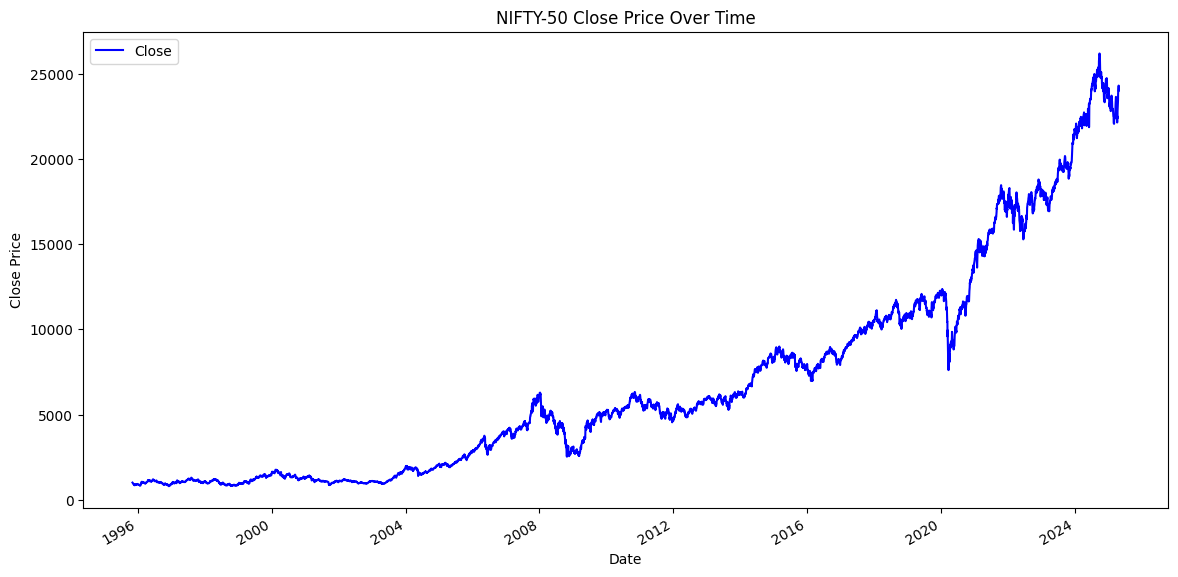

In [9]:
# Plot the Close price over time
nf.plot.line(y='Close', figsize=(14, 7), color='blue')
plt.title('NIFTY-50 Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [10]:
# Create 'Tomorrow' and 'Target' columns
nf["Tomorrow"] = nf["Close"].shift(-1)
nf["Target"] = (nf["Tomorrow"] > nf["Close"]).astype(int)

In [11]:
# Ensure 'Open', 'High', 'Low', 'Close' are numeric
columns_to_convert = ['Open', 'High', 'Low', 'Close']
for col in columns_to_convert:
    nf[col] = pd.to_numeric(nf[col], errors='coerce')


In [12]:
# Drop rows with NaN in important columns
nf = nf.dropna(subset=columns_to_convert + ["Tomorrow"])

In [13]:
# Define predictors
predictors = ["Close", "Open", "High", "Low"]

In [14]:
# Split data into train and test
train = nf.iloc[:-100]
test = nf.iloc[-100:]

In [15]:
# Train the Random Forest model
base_model = RandomForestClassifier(n_estimators=100, random_state=100, min_samples_leaf=1)
base_model.fit(train[predictors], train["Target"])

# Make predictions
preds = base_model.predict(test[predictors])

In [16]:
# Evaluate the model
print("=== Evaluation on Last 100 Days ===")
print("Accuracy Score:", accuracy_score(test["Target"], preds))
print("Precision Score:", precision_score(test["Target"], preds))
print("Recall Score:", recall_score(test["Target"], preds))


=== Evaluation on Last 100 Days ===
Accuracy Score: 0.41
Precision Score: 0.37735849056603776
Recall Score: 0.43478260869565216


In [17]:
# Mean Squared Error
mse = mean_squared_error(test["Target"], preds)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.59


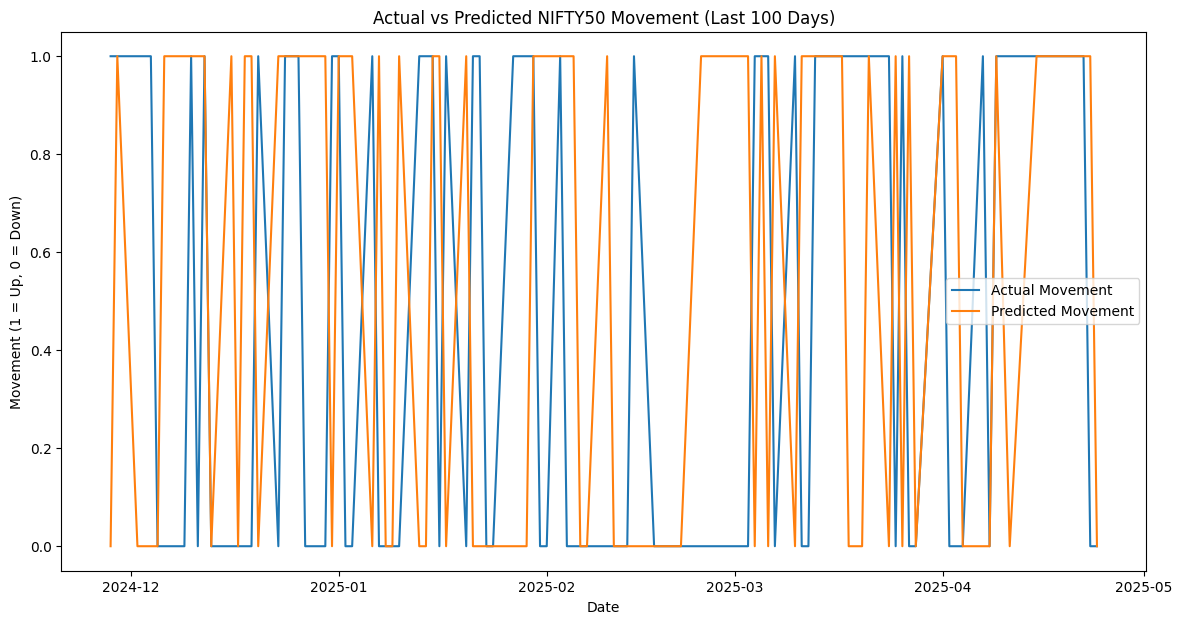

In [18]:
# Plot actual vs predicted
test = test.copy()
test["Predictions"] = preds

plt.figure(figsize=(14, 7))
sns.lineplot(x=test.index, y=test["Target"], label="Actual Movement")
sns.lineplot(x=test.index, y=test["Predictions"], label="Predicted Movement")
plt.title("Actual vs Predicted NIFTY50 Movement (Last 100 Days)")
plt.xlabel("Date")
plt.ylabel("Movement (1 = Up, 0 = Down)")
plt.legend()
plt.show()


In [19]:
# Define a general predict function
def predict(train, test, predictors, model, threshold=0.5):
    model.fit(train[predictors], train["Target"])
    probs = model.predict_proba(test[predictors])[:, 1]
    preds = (probs >= threshold).astype(int)
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [20]:
# Backtest function
def backtest(data, model, predictors, start=2500, step=250, threshold=0.5):
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        preds = predict(train, test, predictors, model, threshold)
        all_predictions.append(preds)
    return pd.concat(all_predictions)

In [21]:
# Run basic backtest
predictions = backtest(nf, base_model, predictors)

In [22]:
# Results
print("\n=== Basic Model Backtest Results ===")
print(predictions["Predictions"].value_counts())
print("Precision Score:", precision_score(predictions["Target"], predictions["Predictions"]))
print("Class Balance:", predictions["Target"].value_counts() / predictions.shape[0])



=== Basic Model Backtest Results ===
Predictions
0    3178
1    1653
Name: count, dtype: int64
Precision Score: 0.5232909860859044
Class Balance: Target
1    0.539019
0    0.460981
Name: count, dtype: float64


In [23]:
# --- Feature Engineering: Moving Averages and Trends ---

horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = nf[predictors].rolling(horizon).mean()
    ratio_column = f"Close_Ratio_{horizon}"
    nf[ratio_column] = nf["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    nf[trend_column] = nf["Target"].shift(1).rolling(horizon).sum()


    new_predictors += [ratio_column, trend_column]


<ipython-input-23-35c326a2e389>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nf[ratio_column] = nf["Close"] / rolling_averages["Close"]
<ipython-input-23-35c326a2e389>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nf[trend_column] = nf["Target"].shift(1).rolling(horizon).sum()
<ipython-input-23-35c326a2e389>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [24]:
# Drop NaNs generated by moving averages
nf = nf.dropna(subset=new_predictors + ["Target"])

# Define a new model for enhanced features
enhanced_model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

# Run backtest with new predictors
predictions = backtest(nf, enhanced_model, new_predictors, threshold=0.6)

In [25]:
# Results
print("\n=== Enhanced Model Backtest Results ===")
print(predictions["Predictions"].value_counts())
print("Precision Score:", precision_score(predictions["Target"], predictions["Predictions"]))
print("Class Balance:", predictions["Target"].value_counts() / predictions.shape[0])

# Final predictions output
predictions


=== Enhanced Model Backtest Results ===
Predictions
0    3296
1     535
Name: count, dtype: int64
Precision Score: 0.5962616822429907
Class Balance: Target
1    0.534847
0    0.465153
Name: count, dtype: float64


,Target,Predictions
Date,,
2009-11-13,1,0
2009-11-16,1,1
2009-11-17,0,0
2009-11-18,0,0
2009-11-19,1,0
...,...,...
2025-04-17,1,1
2025-04-21,1,1
2025-04-22,1,0
